In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/impressionistlandscapespaintings.zip ./
!cd /content/
!unzip impressionistlandscapespaintings.zip
!rm -f impressionistlandscapespaintings.zip
!mv /content/content/drive/MyDrive/impressionist_landscapes_resized_1024 ./
!rm -rf ./content

In [ ]:
# !cp /content/drive/Shareddrives/Sam/Datasets/chinese-landscape-painting-dataset.zip ./
# !mkdir chinese-painting
# !unzip chinese-landscape-painting-dataset.zip -d /content/chinese-painting
# !rm -f chinese-landscape-painting-dataset.zip

In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/landscape-pictures.zip ./
!mkdir landscape-pictures
!unzip landscape-pictures.zip -d /content/landscape-pictures
!rm -f landscape-pictures.zip

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

MAX_DIM = 512
CROP_SIZE = (256, 256)

In [ ]:
STYLE_DIR = 'impressionist_landscapes_resized_1024'

styles = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
len(styles)

5000

In [ ]:
# STYLE_DIR = 'chinese-painting'

# styles2 = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
# len(styles2)

2192

In [ ]:
STYLE_DIR = 'landscape-pictures'

contents = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
len(contents)

4319

In [ ]:
BUFFER_SIZE = 64
BATCH_SIZE = 8

TRAIN, VAL, TEST = 0.9, 0.1, 0.0

train_style = styles[:int(TRAIN*len(styles))]
train_content = contents[:int(TRAIN*len(contents))]

val_style = styles[int(TRAIN*len(styles)):int((TRAIN+VAL)*len(styles))]
val_content = contents[int(TRAIN*len(contents)):int((TRAIN+VAL)*len(contents))]

# test_style = styles[int((TRAIN+VAL)*len(styles)):]
# test_content = contents[int((TRAIN+VAL)*len(contents)):]

In [ ]:
def resize_image(image):
    if not image.shape[0] == None:
        scale = MAX_DIM/max(image.shape)
        image = image.resize((round(image.size[0]*scale), 
                              round(image.size[1]*scale)), Image.ANTIALIAS)
    return image

In [ ]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = resize_image(image)
    image = tf.image.random_crop(image, size=(*CROP_SIZE, 3))
    image = tf.image.convert_image_dtype(image, dtype="float32")
    # image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [ ]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
)

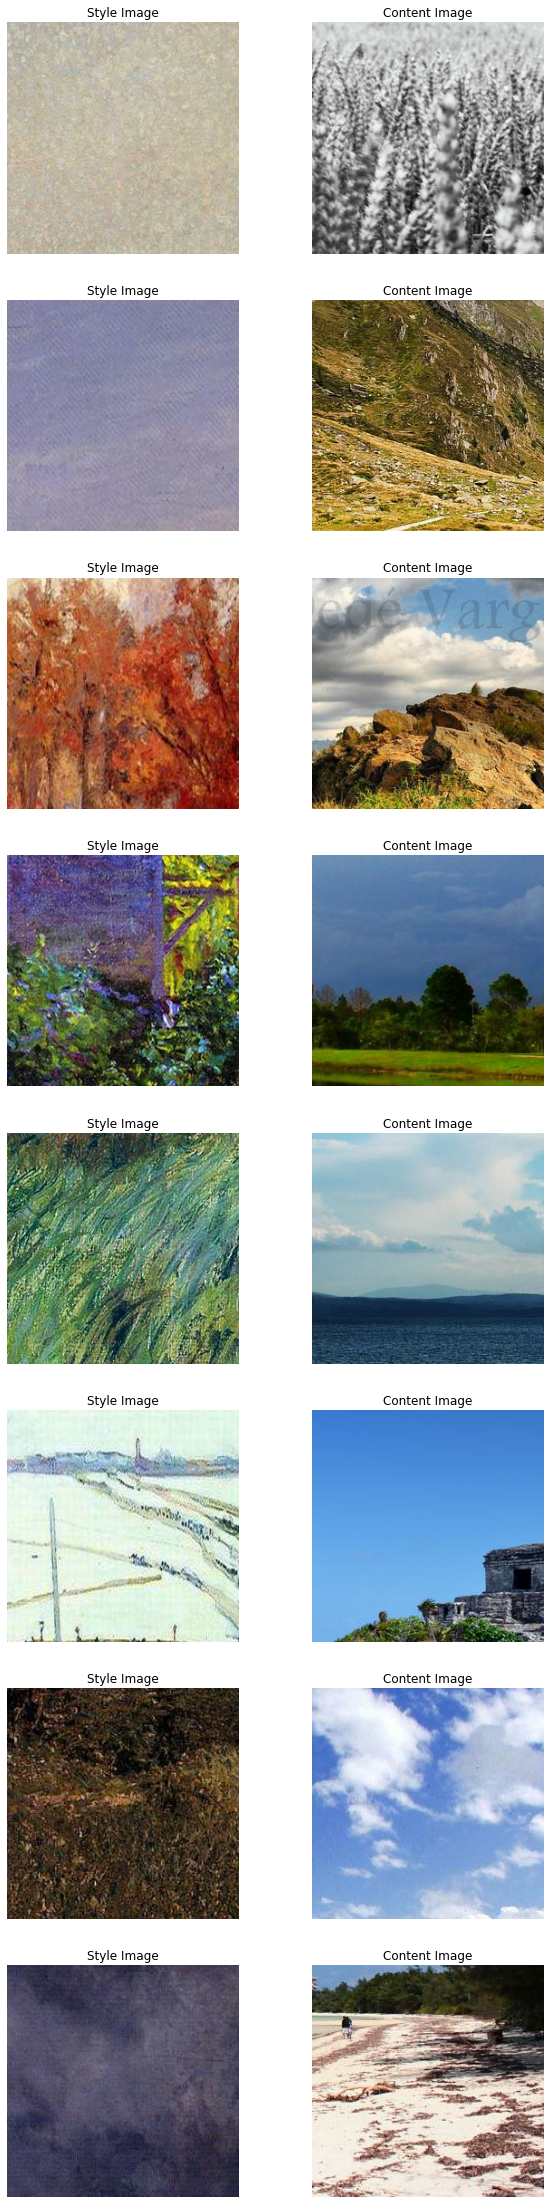

In [ ]:
style_, content_ = next(iter(train_ds))

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style_[0:8], content_[0:8]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

content_layers = ['block4_conv1'] 

num_style_layers = len(style_layers)

In [ ]:
class VGGEncoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

        style_outputs = [vgg.get_layer(name).output for name in style_layers]
        content_outputs = [vgg.get_layer(name).output for name in content_layers]

        model_outputs = style_outputs + content_outputs

        self.vgg = tf.keras.Model(vgg.input, model_outputs)
        self.vgg.trainable = False

    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(inputs)
        return outputs[:num_style_layers], outputs[-1]

In [ ]:
class Conv2DReflect(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv2d = tf.keras.layers.Conv2D(**kwargs)
        self.reflect_size = kwargs['reflect_size'] if 'reflect_size' in kwargs else 1

    def compute_output_shape(self, s):
        return s[0], s[1] + 2 * self.reflect_size, s[2] + 2 * self.reflect_size, s[3]

    def call(self, x):
        x = tf.pad(x,[[0, 0],
                      [self.reflect_size, self.reflect_size],
                      [self.reflect_size, self.reflect_size], 
                      [0, 0]], "REFLECT")
        x = self.conv2d(x)
        return x

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.conv2d1_1 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d1 = tf.keras.layers.UpSampling2D()

        self.conv2d1_2 = Conv2DReflect(filters=256, kernel_size=3,
                                       padding='valid', activation='relu')
        self.conv2d1_3 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d1_4 = Conv2DReflect(filters=256, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d2_1 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d2 = tf.keras.layers.UpSampling2D()

        self.conv2d2_2 = Conv2DReflect(filters=128, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d3_1 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.up2d3 = tf.keras.layers.UpSampling2D()

        self.conv2d3_2 = Conv2DReflect(filters=64, kernel_size=3, 
                                       padding='valid', activation='relu')
        self.conv2d4_1 = Conv2DReflect(filters=3, kernel_size=3, 
                                       padding='valid', activation=None)

    def call(self, inputs):
        x = self.conv2d1_1(inputs)
        x = self.up2d1(x)

        x = self.conv2d1_2(x)
        x = self.conv2d1_3(x)
        x = self.conv2d1_4(x)
        x = self.conv2d2_1(x)
        x = self.up2d2(x)

        x = self.conv2d2_2(x)
        x = self.conv2d3_1(x)
        x = self.up2d3(x)

        x = self.conv2d3_2(x)
        x = self.conv2d4_1(x)

        return x

    def get_image_(self, inputs):
        x = self.call(inputs)
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0) * 255.
        x = tf.cast(x, tf.uint8)
        return x

In [ ]:
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = 1.0

    def mean_std_(x, epsilon=1e-5):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        std = tf.sqrt(var + epsilon)
        return mean, std

    def call(self,content_image_content_feature):
        contents_mean, contents_std = AdaIN.mean_std_(content_image_content_feature)
        t = (content_image_content_feature - contents_mean) / contents_std
        return self.alpha * t + (1.0-self.alpha) * content_image_content_feature

In [ ]:
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
def content_loss(contents, content_targets):
    return loss_fn(contents, content_targets)

In [ ]:
def style_loss_fn(style, style_target):
    style_mean, style_std = AdaIN.mean_std_(style)
    target_mean, target_std = AdaIN.mean_std_(style_target)
    return loss_fn(style_mean, target_mean) + loss_fn(style_std, target_std)

In [ ]:
def style_loss(styles, style_targets):
    return tf.reduce_sum([style_loss_fn(s, t) 
                            for s,t in zip(styles, style_targets)])

In [ ]:
vgg_encoder = VGGEncoder()
decoder = Decoder()
adain = AdaIN()

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
                   initial_learning_rate=1e-4, decay_steps=1.0, decay_rate=5e-5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

In [ ]:
train_total_loss = tf.keras.metrics.Mean(name="total_loss")
train_style_loss = tf.keras.metrics.Mean(name="style_loss")
train_content_loss = tf.keras.metrics.Mean(name="content_loss")

In [ ]:
style_weight = 8.0
content_weight = 1.0

In [ ]:
@tf.function
def train_step(styles):
    styles_s, styles_c = vgg_encoder(styles)

    ada_out = adain(styles_c)

    with tf.GradientTape() as tape:
        outputs = decoder(ada_out)

        reconsts_s, reconsts_c = vgg_encoder(outputs)

        c_loss = content_loss(reconsts_c, ada_out)
        # c_loss = content_loss(reconsts_c, ada_out)
        s_loss = style_loss(reconsts_s, styles_s)

        loss = style_weight * s_loss + content_weight * c_loss

    grads = tape.gradient(loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, decoder.trainable_variables))

    train_total_loss(loss)
    train_style_loss(s_loss)
    train_content_loss(c_loss)

In [ ]:
def test_step():
    styles_test, content_test = next(iter(train_ds))

    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(12, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    styles_s, styles_c = vgg_encoder(styles_test)
    content_s, content_c = vgg_encoder(content_test)

    ada_out = adain(styles_c)

    outputs1 = decoder.get_image_(ada_out)

    ada_out = adain(content_c)

    outputs2 = decoder.get_image_(ada_out)
    
    for (axis, style, reconst1, reconst2, content) in zip(axes, styles_test[0:8], outputs1[0:8], outputs2[0:8], content_test[0:8]):
        (ax_style, ax_content1, ax_reconst2, ax_content) = axis
        
        ax_style.imshow(style)
        ax_style.set_title("Style Image")

        ax_content1.imshow(reconst1)
        ax_content1.set_title("Reconstructed style Image")

        ax_reconst2.imshow(reconst2)
        ax_reconst2.set_title("Reconstructed Content Image")

        ax_content.imshow(content)
        ax_content.set_title("Content Image")
    plt.show()

In [ ]:
epochs = 16
steps_per_epoch = 10000

for i in range(epochs):
    step = 0
    for styles in tqdm(train_style_ds):
        step += 1
        train_step(styles)

        if step >= steps_per_epoch:
            break

    test_step()
    print(
        f"Epoch {i+1}, "
        f"Loss: {train_total_loss.result()}, "
        f"Style Loss: {train_style_loss.result()}, "
        f"Content Loss: {train_content_loss.result()}"
    )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def decode(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    return image

In [ ]:
paths = contents[:8]

images = [decode(p) for p in paths]

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for i, axis in enumerate(axes):
    (ax_content, ax_reconst) = axis

    content_s, content_c = vgg_encoder(images[i][tf.newaxis])

    ada_out = adain(content_c)

    outputs = decoder.get_image_(ada_out)
    
    ax_content.imshow(images[i])
    ax_content.set_title("Content Image")

    ax_reconst.imshow(outputs[0])
    ax_reconst.set_title("Reconstructed Content Image")

plt.show()

In [ ]:
decoder.save('decoder-reconst.h5')

In [ ]:
!cp decoder.h5 /content/drive/Shareddrives/Sam/